# Figure 2 (Part 2). Macaque Cortical Timescale: Spiking vs. ECoG
In this notebook, we compare neuronal population timescale in macaque cortex measured via single unit recordings and surface ECoG.

---
As simulations demonstrate, we can reliably retrieve the autocorrelation decay time constant from the power spectral density of a time series. The natural next question is to ask whether it works on real brain data. Here, we estimated __whole-brain__ cortical timescale recorded via surface ECoG grids from two macaques over 8 sessions total during wakeful rest. To validate our approach, we compare our timescale estimates with previously published spiking timescale estimated from extracellular single-unit spike-train autocorrelograms in [Murray et al., 2014][murray2014]. While our approach offers much broader spatial coverage than possible from isolated single-unit recordings, surface ECoG (and field potentials in general) are fundamentally different signals than single-unit spiking. Specifically, field potentials mainly reflect integrated synaptic and other types of transmembrane currents across many neurons in a local circuit. As such, we examine whether transmembrane current timescale is at all related to known spatial distribution of population spiking timescales.

---
Single-unit timescales are taken from values published in [Murray et al., 2014][murray2014]. ECoG data is taken from the [NeuroTycho repository][neurotycho]. The time periods analyzed are the eyes open resting periods from the "anesthesia & sleep task", to match the single-unit experimental conditions. 2 monkeys with 4 recording sessions each, for 8 recordings total. Power spectral density (PSD) is computed for each channel in each session of roughly 10-minutes long recordings, and timescale is extracted as in Figure 2c.

The below figure (left) shows the sampled areas from Murray 2014 (colored) overlaid on top of the ECoG grid map from one of the macaques in Neurotycho, and their estimated single-unit spiking time constants (right). ECoG electrodes in corresponding areas are selected visually based on the overlapping cortical map and landmark sulci/gyri on the cortex, and averaged across electrodes whenever possible for the regional estimate.

---
# TL;DR:
We find a very strong correlation between single-unit spiking timescales and ECoG (synaptic and transmembrane current fluctuation) timescales, with a consistent scaling factor of ~0.1 (ECoG timescales are ~10x faster than spiking). The correlation and scaling factor is robust across monkeys and sessions, keeping in mind that the spiking and ECoG datasets come from completely different monkeys from across the world, collected from experiments 5-10 years apart.

[murray2014]:https://www.nature.com/articles/nn.3862
[neurotycho]:http://neurotycho.org/anesthesia-and-sleep-task

![](../data/img/chibi_murray_small.png)

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from seaborn import despine

sys.path.append('../')
import echo_utils

font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 14}

import matplotlib
matplotlib.rc('font', **font)
C_ORD = plt.rcParams['axes.prop_cycle'].by_key()['color']

save_plot = True
fig_path = '../figures/neurotycho/%s.pdf'

********************************************************************************
         to build the TVTK classes (8.2). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



### Get spiking population time constants & ECoG results
Spiking timescales are taken directly from Figure 1 of Murray et al., 2014 and averaged over regions.

In [10]:
# get mean population time constants, values grabbed from Murray et al., 2014
cell_ts = {'MT':[77.,64.], 'LIP':[138., 91.], 'LPFC':[184.,180.,195.,162.], 'OFC':[176.,188.], 'ACC':[313.,340.,257.], 'S1':[65.], 'S2':[149.]}
cell_ts_avg = {k: np.array([np.mean(np.array(v)), stats.sem(np.array(v))]) for k,v in cell_ts.items()}

# electrode indices for each of the corresponding areas in each monkey
loc_inds_chibi = {'MT':[3,4,109], 'LIP':[10,11], 'LPFC':[14,15,25,26], 'OFC':[23,34,45], 'ACC':[52,57,58,59], 'S1':[9,19], 'S2':[95,108]}
loc_inds_george = {'MT':[4,13,22], 'LIP':[10,11,20,21], 'LPFC':[15,24,25,26], 'OFC':[45,66], 'ACC':[52,57,58,59], 'S1':[18,19,30], 'S2':[1,2,9,108]}
loc_inds = {'Chibi': loc_inds_chibi, 'George': loc_inds_george}

area_ord = [3,1,2,0,4,6,5] # color order to match Murray figure

# load ecog results dataframe
df_combined = pd.read_csv('../data/df_macaque.csv', index_col=0)

# ECoG and spiking timescale comparison

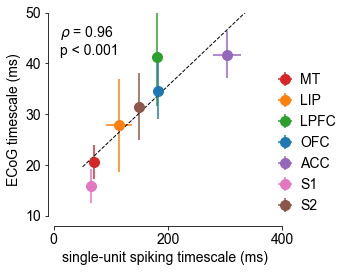

In [90]:
# define querying condition
feature = 'tau'
cond_query = 'EyesOpen'
df_cond = df_combined[df_combined['cond']==cond_query] 

# plot
plt.figure(figsize=(5,4))
ecog_ts_avg = {}

# plot per session average across electrodes
for i, k in enumerate(cell_ts.keys()):
    sesh_mkrs = [] # hack to save the session marker for next plot
    ecog_ts_avg[k] = []
    for s in df_cond['session_id'].unique():
        df_sesh = df_cond[df_cond['session_id']==s]
        patient = df_sesh['patient'].iloc[0]

        # loc_inds has the ecog electrode indices that fall into each area
        region_inds = loc_inds[patient][k] 
        marker = 's' if patient == 'George' else '^'
        sesh_mkrs.append(marker)
        ecog_ts_sess_avg = df_sesh.loc[df_sesh['chan'].isin(region_inds)].mean()[feature]*1e3 # use ms
        ecog_ts_avg[k].append(ecog_ts_sess_avg)

# plot grand average
for i,k in enumerate(cell_ts.keys()):
    plt.errorbar(cell_ts_avg[k][0], np.mean(ecog_ts_avg[k]), xerr=cell_ts_avg[k][1], yerr=stats.sem(ecog_ts_avg[k]), fmt='o', color=C_ORD[area_ord[i]], ms=10, label=k)
    
# fit & plot line
ts_mat = np.array([(cell_ts_avg[k][0], np.mean(ecog_ts_avg[k])) for k in cell_ts.keys()])
m,b,r,pv,stderr = stats.linregress(ts_mat)
XL = np.array(plt.xlim())
plt.plot(XL, m*XL+b, 'k--', lw=1)

rho, pv = stats.spearmanr(ts_mat[:,0], ts_mat[:,1])
s = echo_utils.sig_str(rho, pv, form='text')
plt.annotate(s, xy=(0.05, 0.8), xycoords='axes fraction')

plt.tick_params('x', which='minor', bottom=False, labelbottom=False)
plt.tick_params('y', which='minor', left=False, labelleft=False)
plt.xlim([-10,400]);plt.ylim([8,50]);
echo_utils.set_ticks_truncate_axes(xt=([0, 200, 400], None), yt=(np.arange(10,60,10), None))

plt.legend(loc='lower left', bbox_to_anchor= (0.9, 0), ncol=1, frameon=False, handletextpad=0.05)
plt.xlabel('single-unit spiking timescale (ms)');plt.ylabel('ECoG timescale (ms)'); #plt.title(cond_query)
despine(); plt.tight_layout()

if save_plot: plt.savefig(fig_path%('tau_ECoGSpike_'+cond_query), bbox_inches='tight')

### ECoG timescale correlates strongly with spiking timescale
Across sessions, we find that single-unit spiking timescale correlates strongly with ECoG timescale (correlation effect size and p-value from linear regression model, using grand mean of both spiking and ECoG data as independent and dependent variables, respectively). Grand mean of ECoG time constants also follow a cortical hierarchy, as shown in the original single-unit study.

Note that there was no exact OFC ECoG coverage in either monkeys, so the closest electrodes were taken, around the frontal pole. Also note that individual sessions (hollow markers) are quite variable, and there are consistent differences between monkeys (square vs. triangle). Therefore, we look at the consistency of fits between individual sessions.

---

### Fitting linear model to individual sessions

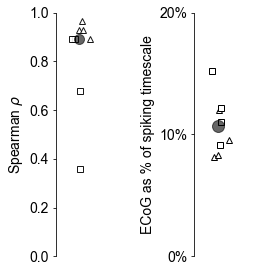

In [91]:
ecog_ts_mat = np.array([ecog_ts_avg[k] for k in cell_ts.keys()])
cell_ts_mat = np.array([cell_ts_avg[k][0] for k in cell_ts.keys()])
session_stats = np.array([stats.linregress(cell_ts_mat, ecog_ts_mat[:,i]) for i in range(ecog_ts_mat.shape[1])])
session_rhos = np.array([stats.spearmanr(cell_ts_mat, ecog_ts_mat[:,i]) for i in range(ecog_ts_mat.shape[1])])

plt.figure(figsize=(4,4))
plt.subplot(1,2,1)
for s_i, s in enumerate(sesh_mkrs): plt.plot(np.random.randn(1)/10, session_rhos[s_i,0],mec='k', mfc='w', ms=6, marker=s, alpha=0.9)
plt.plot(0, r,'ko', ms=10, alpha=0.6)
plt.xlim([-0.5,1]); plt.ylim([0,1]);
plt.xticks([]); plt.ylabel(r'Spearman $\rho$')

plt.subplot(1,2,2)
for s_i, s in enumerate(sesh_mkrs): plt.plot(np.random.randn(1)/10, session_stats[s_i,0]*100, mec='k', mfc='w', ms=6, marker=s)
plt.plot(0, m*100,'ko', ms=12, alpha=0.6)
plt.xlim([-0.5,1]);
plt.yticks([0, 10, 20], ['0%', '10%', '20%'])
plt.xticks([]); plt.ylabel('ECoG as % of spiking timescale')

despine(bottom=True)
plt.tight_layout(); 
if save_plot: plt.savefig(fig_path%('tau_ECoGSpikeScaling_'+cond_query), bbox_inches='tight')

### Correlation across sessions is consistent
While variable across sessions and monkeys (Subj. C and G), correlation coefficients are consistently high. The two timescales don't match one-to-one, however. There is a consistent scaling factor of about 10 (i.e., $\tau_{spiking}$ = 10\*$\tau_{ECoG}$), suggesting two separate but dependent processes. Notably, and consistent with the interpretation that field potentials reflect synaptic and transmembrane current timescale, ECoG-estimated timescale are on the order of 10-100ms, which closely resembles passive membrane potential time constant. Transmembrane current timescale is affected by both intrinsic cellular properties (e.g., dendritic integration, membrane capacitance and resistance, etc.) and synaptic properties (expression of long-timescale synapses like NMDA). It's likely that the timescale readout estimated from the current method reflects (filtered synaptic) inputs to the local population, rather than the spiking output.

---
---

# Supplemental & Extra Goodies

### Plot tau along anterior-posterior axis

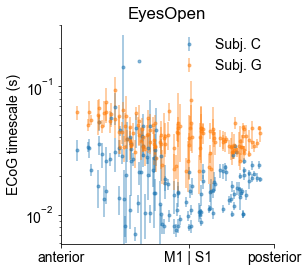

In [93]:
feature = 'tau'
plt.figure(figsize=(4.5,4))
# group by subject at the highest level, then channel, then perform average (over sessions)
grand_agg = df_cond.groupby(['patient', 'chan'])[df_combined.columns[3:]].agg([np.nanmean, stats.sem])
for g_i, g in grand_agg.groupby('patient'):
    plt.errorbar(g['y']['nanmean'], g[feature]['nanmean'], yerr=g[feature]['sem']*2., fmt='.', alpha=0.5)
    # normalize per subject
    #plt.errorbar(g['y']['nanmean'], g[feature]['nanmean']/g[feature]['nanmean'].min(), yerr=g[feature]['sem']*2., fmt='.')
    
plt.yscale('log'); plt.legend(['Subj. C', 'Subj. G'], frameon=False); 
plt.xticks([0,600,1000],['anterior','M1 | S1','posterior'])
plt.ylabel('ECoG timescale (s)'); plt.title(cond_query)
despine(); plt.tight_layout()
if save_plot: plt.savefig(fig_path%('TauAcrossAP_'+cond_query))

### Timescale increases from sensorimotor areas towards frontal and occiptal poles
Having confirmed a correspondence between spiking and ECoG timescales, we can take advantage of the full cortex coverage provided by the ECoG data to measure timescale across the entire brain. Sensorimotor regions (near central sulcus) have the shortest timescale, while frontal regions have the longest timescales. Visual cortex, surprisingly, does not have the shortest timescale. Also note the offset between the two monkeys while preserving the relative spatial relationship.

---
### Eyes open vs. eyes closed

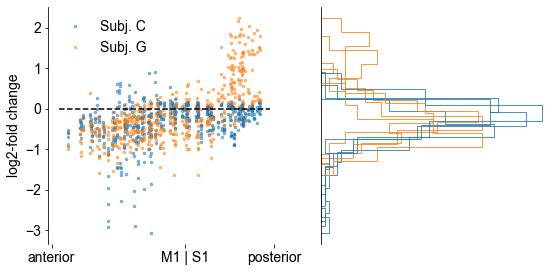

In [94]:
feature = 'tau'
conds_comp = ['EyesOpen','EyesClosed']
plt.figure(figsize=(8,4))
for s in df_combined['session_id'].unique():
    df_comp = [df_combined[np.logical_and(df_combined['cond']==c, df_combined['session_id']==s)] for c in conds_comp]

    # check that the subsampled rows are properly aligned in space and session
    #print(np.logical_and(df_comp[1]['y']==df_comp[1]['y'],df_comp[1]['session_id']==df_comp[1]['session_id']).all())
    cond_ratio = np.log2(df_comp[1][feature].values/df_comp[0][feature].values)
    C = C_ORD[0 if df_comp[0].iloc[0]['patient']=='Chibi' else 1]

    # plot along A-P axis
    plt.subplot(1,2,1)
    plt.plot(df_comp[1]['y'], cond_ratio, '.', color=C, alpha=0.5, ms=5)
    
    # plot histogram
    plt.subplot(1,2,2)
    plt.hist(cond_ratio[~np.isnan(cond_ratio)], 10, histtype='step', color=C, orientation='horizontal', alpha=0.8)

plt.subplot(1,2,1)
plt.plot(plt.xlim(),[0,0],'k--')
plt.legend(['Subj. C', 'Subj. G'], frameon=False); 
plt.xticks([0,600,1000],['anterior','M1 | S1','posterior'])
plt.ylabel('log2-fold change'); despine()

plt.subplot(1,2,2)
plt.xticks([]); plt.yticks([])
despine(bottom=True); plt.tight_layout()
if save_plot: plt.savefig(fig_path%('tau_EO2EC'), bbox_inches='tight')

---
# Timescale vs. scale-free (tau-exp correlation)

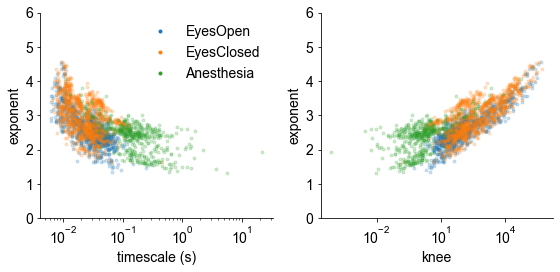

In [7]:
plt.figure(figsize=(8,4))
for cond in df_combined['cond'].unique()[[0,1,3]]:
    df_plot = df_combined[df_combined['cond']==cond]
    plt.subplot(1,2,1)
    plt.semilogx(df_plot['tau'],df_plot['exp'],'.', alpha=0.2, label=cond)
    plt.xlabel('timescale (s)'); plt.ylabel('exponent'); plt.ylim([0, 6]);
    
    # knee-exp
    plt.subplot(1,2,2)
    plt.semilogx(df_plot['knee'],df_plot['exp'],'.', alpha=0.2, label=cond)
    plt.xlabel('knee'); plt.ylabel('exponent'); plt.ylim([0, 6]);

plt.subplot(1,2,1); 
lg=plt.legend(fancybox=False, frameon=False)
for l in lg.legendHandles: l._legmarker.set_alpha(1)
despine(); plt.tight_layout()
if save_plot: plt.savefig(fig_path%'tau_exp')

### Timescale is correlated with "scale-free" processes
In all the conditions, the PSD exponent ("scale-free") and time constant (characteristic timescale) are very correlated. Note that FOOOF estimates PSD exponent for the portion past the knee, and thus should be independent of the change in timescale. 

If there are two separate processes, then they are very related to each other. Or perhaps we are characterizing a single process in two different ways. Importantly, this is not an artifact of the timescale computation, which accounts for exponent, as that would induce the opposite correlation (see human ECoG notebook ./supp_viz_MNI_rest.ipynb for simulation).

---

### Initial notes on macaque ECoG vs. spiking timescale
Single unit spiking timescales correlate with ECoG characteristic timescales across cortical areas. More generally, timescale increases moving from posterior to anterior regions of the brain, "up the cortical hierarchy".

However, there is a conversion factor of ~0.1 from ECoG to spiking, i.e. ECoG timescale is 1/10 of single unit spike timing timescale. Why is that?
1. timescale correlation is due to chance, or some other factor in the ECoG, e.g., dendritic/membrane integration constant
2. spiking is local output, whereas ECoG is (mostly) input, so the time constant measured in ECoG is spiking from the afferent region
3. single unit time constant is different from population time constant, which has been proposed as the benefit of asynchronous population spiking (faster reaction, e.g., van Vreeswijk, Destexhe)
4. local recurrent dendritic processes "filter" spiking, most likely in a low-pass fashion. Thus, whatever process with the highest time constant (lower frequency knee) will dominate in the retrieved timescale
5. they have nothing to do with each other and this is just random

**Should try gamma or broadband power autocorrelation over time to match with the spiking timescale.**

---
### Slope vs. knee
Current points of investigation:
- Median fit knee is most consistent in correlating with timescale, and in general, produces more robust fits for the PSD (fewer nans, i.e., negative knees).

- When fit with knee, slope also (negatively) correlates with single unit time constant. However, when just fit using a line in the full range, slope does NOT correlate with time constant. This is surprising, as I would have expected the knee-removed slope to be independent of the timescale, and the non-knee-removed slope fits are essentially corrupted by the knee. This indicates that the characteristic timescale (in exponential decay) is correlated with the power-law decay (???), suggesting multiple processes with multiple temporal time characteristics.

- For example, exponential decay constant (knee) may arise from synaptic time constant, while the power law relation may be from population spiking autocorrelation.